# Table of contents
1. [Abstract](#abstract)
2. [Scrape Wikipedia for stock tickers](#scrape)
3. [Select stocks](#select)
4. [Simple moving average](#sma)
5. [Backtesting](#backtest)

## Abstract <a name='abstract'></a>
In this project, we first scrape the web for the ticker information of the S&P 500 constituents. Then we apply a Simple Moving Average trading strategy to a basket of 11 stocks and compare the performance of the active strategy against that of the S&P 500 through backtesting.

## Scrape Wikipedia for stock tickers <a name='scrape'></a>

First, we scrape the [S&P 500 page on Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)  for company ticker and sector information. 

In [21]:
# Import packages
import time

import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from bs4 import BeautifulSoup

In [7]:
# Visit page and grab html
r = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(r.text, 'lxml')

# Extract company info
table = soup.find_all('table')[0]
rows = table.find_all('tr')
dictionaries = []
for row in rows[1:]:
    ticker, company, _, sector, _, _, _, _ = row.find_all('td')
    company_dict = {'ticker': ticker.text, 'company': company.text, 'sector': sector.text}
    dictionaries.append(company_dict)
    
# Organize in a dataframe
companies_df = pd.DataFrame(dictionaries)
print('Total number of companies: {}'.format(companies_df.shape[0]))

Total number of companies: 505


There are 505 companies in total. The first 10 companies (in alphabetical order) are shown below as an example.

In [8]:
companies_df.head(10)

,company,sector,ticker
0,3M Company,Industrials,MMM
1,Abbott Laboratories,Health Care,ABT
2,AbbVie Inc.,Health Care,ABBV
3,Accenture plc,Information Technology,ACN
4,Activision Blizzard,Information Technology,ATVI
5,Acuity Brands Inc,Industrials,AYI
6,Adobe Systems Inc,Information Technology,ADBE
7,Advanced Micro Devices Inc,Information Technology,AMD
8,Advance Auto Parts,Consumer Discretionary,AAP
9,AES Corp,Utilities,AES


## Select stocks <a name='select'></a>

We grab the daily trading volume for every stock in the S&P 500 for an entire year using the Yahoo Finance API, and then calculate the daily average volume as a proxy for the liquidity of that stock.

In [4]:
volume_start = '2016-12-09'
volume_end = '2017-12-08'
tickers = list(companies_df['ticker'])

# Grab daily trading volume from Yahoo Finance API for an entire year
# and calculate average daily trading volume
avg_volumes = []
t0 = time.time()
for ticker in tickers:
    try:
        avg_volume = pdr.data.DataReader(ticker, 'yahoo', volume_start, volume_end)['Volume'].mean()
        avg_volumes.append(avg_volume)
    except:
        avg_volumes.append(np.nan)
t1 = time.time()
print('It took {} seconds to get daily trading volume for every stock in the S&P 500 for an entire year.'.format(t1 - t0))

It took 633.8800871372223 seconds to get daily trading volume for every stock in the S&P 500 for an entire year.


We add this newly acquired volume metric to the existing dataframe. It now looks like this.

In [9]:
companies_df['avg_volume'] = avg_volumes
companies_df.head(10)

,company,sector,ticker,avg_volume
0,3M Company,Industrials,MMM,1.834737e+06
1,Abbott Laboratories,Health Care,ABT,6.706854e+06
2,AbbVie Inc.,Health Care,ABBV,NaN
3,Accenture plc,Information Technology,ACN,2.136195e+06
4,Activision Blizzard,Information Technology,ATVI,6.730071e+06
5,Acuity Brands Inc,Industrials,AYI,6.998952e+05
6,Adobe Systems Inc,Information Technology,ADBE,2.461865e+06
7,Advanced Micro Devices Inc,Information Technology,AMD,6.604732e+07
8,Advance Auto Parts,Consumer Discretionary,AAP,1.632054e+06
9,AES Corp,Utilities,AES,5.280043e+06


Companies in the S&P 500 belong to 11 unique sectors, as shown below.

In [13]:
for sector in set(companies_df['sector']):
    print(sector)

Financials
Real Estate
Energy
Utilities
Industrials
Health Care
Information Technology
Consumer Discretionary
Materials
Telecommunication Services
Consumer Staples


We choose our stock universe based on the following two criteria
- Diversification: We will invest in all 11 sectors of the S&P 500 to get broad exposure to different industries in order to get diversification benefits
- Liquidity: In each sector, we will invest in the most liquid stock as measured by the average daily trading volume of the past year

The 11 companies we will invest in are as follows. As expected, most of them are household names in their respective industries.

In [14]:
select_stocks = companies_df.sort_values('avg_volume', ascending=False).drop_duplicates('sector')
select_stocks

,company,sector,ticker,avg_volume
66,Bank of America Corp,Financials,BAC,8.096559e+07
7,Advanced Micro Devices Inc,Information Technology,AMD,6.604732e+07
213,General Electric,Industrials,GE,4.435513e+07
204,Ford Motor,Consumer Discretionary,F,3.700101e+07
106,Chesapeake Energy,Energy,CHK,3.534239e+07
366,Pfizer Inc.,Health Care,PFE,2.009576e+07
473,Verizon Communications,Telecommunication Services,VZ,1.539244e+07
278,Kroger Co.,Consumer Staples,KR,1.198355e+07
241,Host Hotels & Resorts,Real Estate,HST,7.291544e+06
158,DowDuPont,Materials,DWDP,6.314125e+06


In [15]:
# Save selected companies in Excel file
select_stocks.to_excel('Select Companies.xlsx', index=False)

We choose a 5-year period from Dec. 2012 to Dec. 2017 as our back-testing window. Notice how we use daily trading volume from Dec. 2016 to Dec. 2017 to pick the stock universe. This earlier timeframe is chosen on purpose so as not to commit survivorship bias when choosing the stock universe.

The code snippet below completes several data preprocessing steps
- Grab the historical stock price for the selected stocks for the 5-year window. Specifically, we are interested in the adjusted closing price, which is normalized for corporate actions like stock spliting
- There's no pricing data on weekends and holidays, so we focus only on the weekdays
- Fill missing values by using the last available data point (usually from the previous trading day)

Pricing data for the first 10 trading days in our back-testing period is shown below as an example. Notice we've added the S&P 500 index to the ticker list. Even though we will not be actively trading in the index, we've included it as a return benchmark.

In [17]:
tickers += ['^GSPC']
start_date = '2012-12-09'
end_date = '2017-12-08'
adj_close = pdr.data.DataReader(tickers, 'yahoo', start_date, end_date)['Adj Close']

weekdays = pd.date_range(start_date, end_date, freq='B')
adj_close = adj_close.reindex(weekdays)
adj_close = adj_close.fillna(method='ffill')
adj_close.head(10)

,AMD,BAC,CHK,DWDP,F,GE,HST,KR,NRG,PFE,VZ,^GSPC
2012-12-10,2.32,10.018538,15.408631,28.817234,9.207389,18.106077,12.451697,12.303453,20.235111,21.309782,35.113468,1418.550049
2012-12-11,2.33,9.961668,15.499323,29.231462,9.223442,18.207657,12.558613,12.280373,20.472305,21.502670,35.440434,1427.839966
2012-12-12,2.37,10.056451,15.381424,29.325605,9.207389,18.436203,12.525714,12.275753,20.600031,21.393644,35.719551,1428.479980
2012-12-13,2.41,9.990103,15.127484,29.212633,9.046843,18.300772,12.468143,12.164955,20.746000,21.242693,35.504230,1419.449951
2012-12-14,2.39,10.028016,15.018655,29.579790,8.910376,18.300772,12.550387,12.137253,20.983210,21.116896,35.257011,1413.579956
2012-12-17,2.46,10.426104,15.181900,29.956366,9.143171,18.563177,12.599735,12.266522,21.393745,21.267853,35.185234,1430.359985
2012-12-18,2.52,10.767323,15.644432,30.869558,9.367936,18.360023,12.887587,12.349623,21.083559,21.502670,34.985863,1446.790039
2012-12-19,2.52,10.606192,15.599085,30.530642,9.416101,17.784418,12.797119,12.234205,20.782495,21.259464,34.595097,1435.810059
2012-12-20,2.40,10.918974,15.943716,30.587128,9.448213,17.980888,13.043849,12.294222,21.156546,21.326557,34.938011,1443.689941
2012-12-21,2.59,10.700974,15.707915,30.116409,9.520457,17.835670,12.994503,12.141869,20.864605,21.033039,34.746616,1430.150024


To get a general sense of the performance of each stock in our basket, we plot below the cumulative return of each stock.

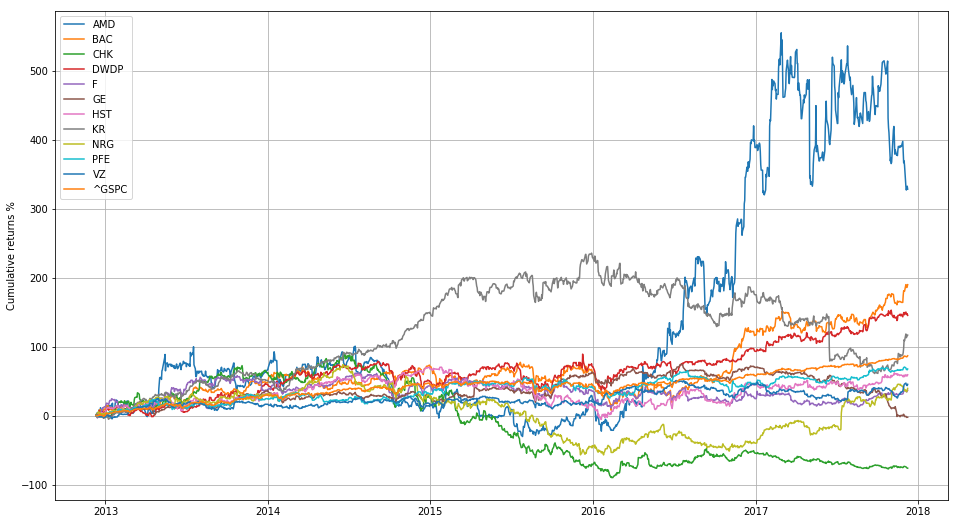

In [20]:
# Calculate log returns
log_returns = np.log(adj_close).diff()

# Plot cumulative returns
fig = plt.figure(figsize=[16,9])
ax = fig.add_subplot(1,1,1)

for c in log_returns:
    ax.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum()) - 1), label=str(c))

ax.set_ylabel('Cumulative returns %')
ax.legend(loc='best')
ax.grid()

plt.show()

Now we calculate the average daily return for each stock. Since these are daily returns, they are expected to be very small in magnitutde.

In [47]:
# Calculate daily returns
returns = adj_close.pct_change(1)
mean_returns = returns.mean()
print('Average daily return from {} to {} for each stock (in demimal points):'.format(start_date, end_date))
mean_returns

Average daily return from 2012-12-09 to 2017-12-08 for each stock (in demimal points):


AMD      0.001785
BAC      0.000940
CHK     -0.000286
DWDP     0.000795
F        0.000339
GE       0.000049
HST      0.000463
KR       0.000706
NRG      0.000556
PFE      0.000450
VZ       0.000337
^GSPC    0.000507
dtype: float64

The correlation matrix of the daily returns are presented below.

In [24]:
# Calculate return correlation matrix
returns_corr = returns.corr()
returns_corr

,AMD,BAC,CHK,DWDP,F,GE,HST,KR,NRG,PFE,VZ,^GSPC
AMD,1.000000,0.234156,0.156249,0.212552,0.217034,0.153546,0.199764,0.052129,0.161248,0.135170,0.102426,0.299855
BAC,0.234156,1.000000,0.285806,0.439478,0.487407,0.435539,0.436171,0.241166,0.219524,0.359603,0.216263,0.672044
CHK,0.156249,0.285806,1.000000,0.297533,0.272602,0.231792,0.304884,0.037169,0.343430,0.154970,0.142241,0.333138
DWDP,0.212552,0.439478,0.297533,1.000000,0.395449,0.424401,0.406230,0.188250,0.275131,0.338798,0.290190,0.621130
F,0.217034,0.487407,0.272602,0.395449,1.000000,0.425313,0.438900,0.232311,0.193046,0.307193,0.298355,0.611333
GE,0.153546,0.435539,0.231792,0.424401,0.425313,1.000000,0.406960,0.218493,0.203712,0.393088,0.359821,0.635315
HST,0.199764,0.436171,0.304884,0.406230,0.438900,0.406960,1.000000,0.238480,0.284834,0.317014,0.334380,0.620750
KR,0.052129,0.241166,0.037169,0.188250,0.232311,0.218493,0.238480,1.000000,0.091950,0.246354,0.239541,0.372319
NRG,0.161248,0.219524,0.343430,0.275131,0.193046,0.203712,0.284834,0.091950,1.000000,0.162386,0.190909,0.347919
PFE,0.135170,0.359603,0.154970,0.338798,0.307193,0.393088,0.317014,0.246354,0.162386,1.000000,0.308190,0.593173


It might be easier to color code the pair-wise correlations on a gradient scale. That way it'll be really easy to visually identify the particularly strong positive and negative correaltions. We show a color coded version of the same correlation matrix below.

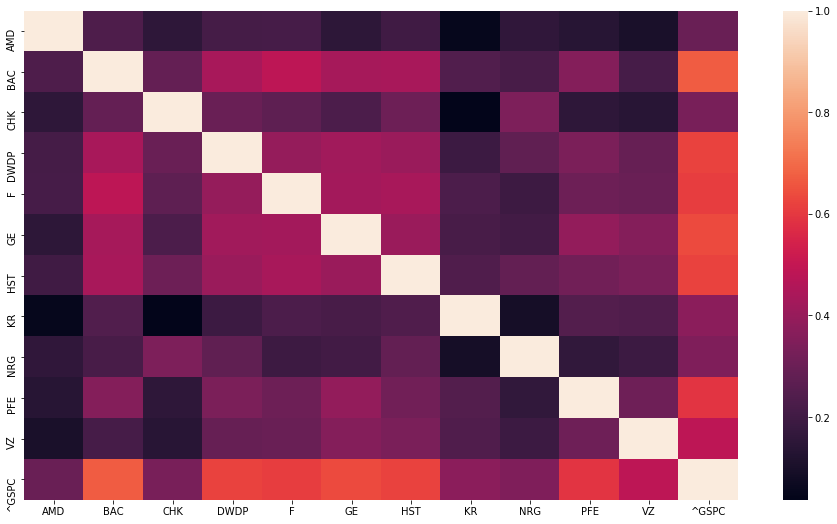

In [25]:
# Plot color coded correlation matrix
fig = plt.figure(figsize=[16,9])
fig = sns.heatmap(returns_corr, xticklabels=returns_corr.columns, yticklabels=returns_corr.columns)
plt.show()

The diagonal of the matrix has all 1's, as it measures the correlation of a particular stock with itself. The rest of the matrix (which is symmetrical) measures all possible pairwise correlations within our stock universe. Interestingly, all of the correlations are positive, meaning the return of every stock is positively correlated with that of any other stock in the stock universe, at least based on empirical data from 2012 to 2017. This overarching positive correlation theme might have implications for the performance of our trading strategy, specifically the diversification benefit we were hoping to get by investing in each sector of the S&P 500 might not be as great as we'd hoped.

## Simple moving average <a name='sma'></a>

Our trading strategy utilizes the simple moving average (SMA) of the stock price. As the name implies, the moving average of a stock price is a time series that consists of average stock prices in a time window of fixed size that moves forward in time. For instance, suppose the closing price of a particular stock for a week are
- Mon: 1
- Tue: 2
- Wed: 3
- Thu: 4
- Fri: 5

Given a window size of 3 days, the moving average of this price history would be
- $SMA_{Wed} = \frac{1 + 2 + 3}{3}$ = 2
- $SMA_{Thu} = \frac{2 + 3 + 4}{3}$ = 3
- $SMA_{Fri} = \frac{3 + 4 + 5}{3}$ = 4

Notice the first available SMA point is on Wednesday. This is because for a window size of 3 days, the first data point will need the first 3 observations in our sample.

We test two versions of the SMA, one with a 20-day window and another with a 100-day window. To get a sense of how SMA's look next to the contenporaneous stock price, we plot below the daily closing price of the S&P 500 index along with the 20-day SMA and the 100-day SMA of the stock price.

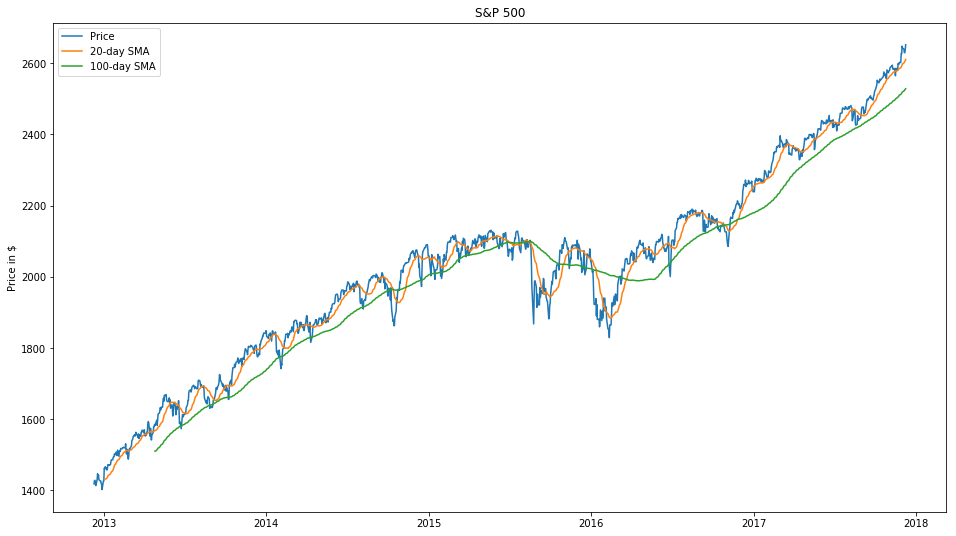

In [26]:
# Calcuate two versions of the moving average
short_sma = adj_close.rolling(window=20).mean()
long_sma = adj_close.rolling(window=100).mean()

# Plot SMAs along with contemp price
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

ax.plot(adj_close['^GSPC'].index, adj_close['^GSPC'], label='Price')
ax.plot(short_sma['^GSPC'].index, short_sma['^GSPC'], label = '20-day SMA')
ax.plot(long_sma['^GSPC'].index, long_sma['^GSPC'], label = '100-day SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.set_title('S&P 500')
plt.show()

As is clear from the graph, the two SMA's smoothed out some of the short-term noises in the contemporaneous stock price, and the higher the SMA window, the more noise is smoothed out. Another important observation is that, while appearing more smooth, the two SMA series lag the contemporaneous price series whenever there's a significant price movement. This is just a product of how SMA's are defined and calculated, and can be viewed as an inherent weakness of SMA strategies, as price movements will only get reflected in SMAs way after they actually occur. That said, we can actually use the lagging nature of SMA's as a trading signal. Our strategy is as follows
- Everytime the contenporaneous stock price crosses the SMA price from above, it might be a sign that the long-term price trend is going down. Therefore, we short the stock
- Conversely, everytime the contemporaneous stok price crosses the SMA price from below, it might be a sign that the long-term price trend is going up. Therefore, we long the stock
- As for how much we long and short each stock, we keep it simple and make it 1/11 of the entire portfolio (i.e., equally weighted given 11 stocks)

## Backtesting <a name='backtest'></a>

This strategy is actually pretty straightforwad to implement in Python. We simply take the difference between the contemporaneous price and the SMA price, and adjust our position only when there's a sign change in the difference. One nuisance here is that we are using the closing price as of day $t$ to determine the trading position for the next day, $t + 1$. In other words, whatever trading position we came up with from the previous step will need to be "shifted" by 1 day because those positions will only be applicable on the next trading day. Finally, we are setting a weight of 1 to the S&P 500 index to always long the index and use that as a return benchmark. Trading positions for the last 10 days in the backtesting window are shown below as an example.

In [41]:
# Calculate trading positions
# trading_positions = adj_close - short_sma
trading_positions = adj_close - long_sma
num_stocks = len(tickers) - 1
trading_positions = trading_positions.apply(np.sign) * 1/num_stocks
trading_positions['^GSPC'] = 1
trading_positions = trading_positions.shift(1)
trading_positions.tail(10)

,AMD,BAC,CHK,DWDP,F,GE,HST,KR,NRG,PFE,VZ,^GSPC
2017-11-27,-0.083333,0.083333,-0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0
2017-11-28,-0.083333,0.083333,-0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0
2017-11-29,-0.083333,0.083333,-0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0
2017-11-30,-0.083333,0.083333,-0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0
2017-12-01,-0.083333,0.083333,-0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0
2017-12-04,-0.083333,0.083333,0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0
2017-12-05,-0.083333,0.083333,-0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0
2017-12-06,-0.083333,0.083333,-0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0
2017-12-07,-0.083333,0.083333,-0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0
2017-12-08,-0.083333,0.083333,-0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,1.0


To make it more explicit when we are changing trading positions, we plot below both the contemporaneous and SWA price of one of the stocks in our univese, General Electric, along with the trading position for that stock. Notice we only switch our position (meaning going from long to short or vice versa) when the two series cross. Whether we go from long to short or the other way depends on the relative position of the two series before and after the crossing.

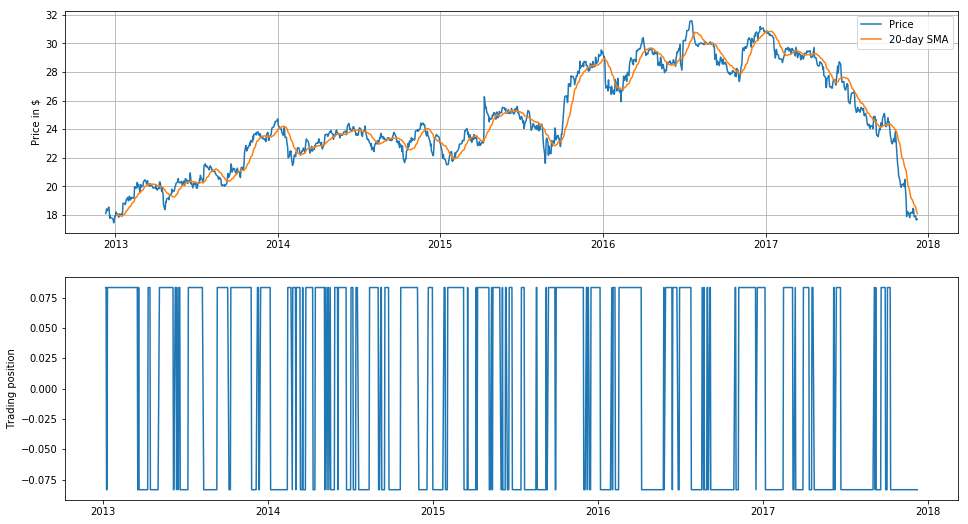

In [30]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(2,1,1)

ax.plot(adj_close['GE'].index, adj_close['GE'], label='Price')
ax.plot(short_sma['GE'].index, short_sma['GE'], label = '20-day SMA')

ax.set_ylabel('Price in $')
ax.legend(loc='best')
ax.grid()

ax = fig.add_subplot(2,1,2)

ax.plot(trading_positions['GE'].index, trading_positions['GE'], label='Trading position')

ax.set_ylabel('Trading position')

plt.show()

Since we now have both the daily return and trading position of each stock, it's possible to show the cumulative return of each of the stocks (simply the product of the daily return and the trading position entering into that day), which we show below.

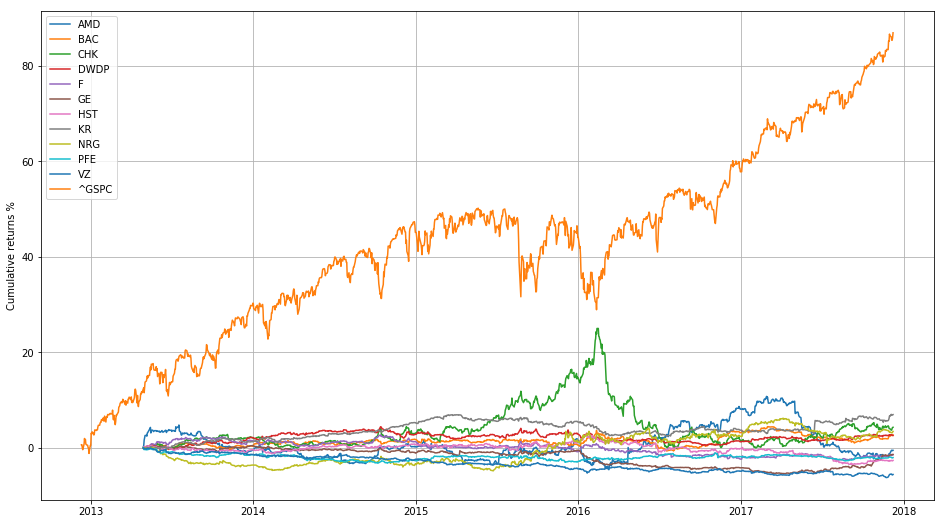

In [42]:
asset_log_returns = trading_positions * log_returns
cum_asset_log_returns = asset_log_returns.cumsum()
cum_asset_returns = np.exp(cum_asset_log_returns) - 1

# Plot cumulative returns by asset
fig = plt.figure(figsize=[16,9])
ax = fig.add_subplot(1,1,1)

for c in cum_asset_returns:
    ax.plot(cum_asset_returns.index, 100*cum_asset_returns[c], label=str(c))

ax.set_ylabel('Cumulative returns %')
ax.legend(loc='best')
ax.grid()

plt.show()

What's immediately apparent from this graph is that a simple buy and hold strategy for the S&P 500 index would've produced very respectable returns for the 2012-2017 period. 

To calculate the cumulative returns for the trading strategy, we simply need to add up each row of cum_asset_returns (excluding the last column, which corresponds to the S&P 500 index).

In [43]:
# Calculate cumulative return of active and passive trading strategies
cum_strategy_returns = cum_asset_returns[tickers[:-1]].sum(axis=1)
cum_sp500_returns = cum_asset_returns[tickers[-1]]

In [40]:
cum_strategy_returns_20sma = cum_strategy_returns

In [44]:
cum_strategy_returns_100sma = cum_strategy_returns

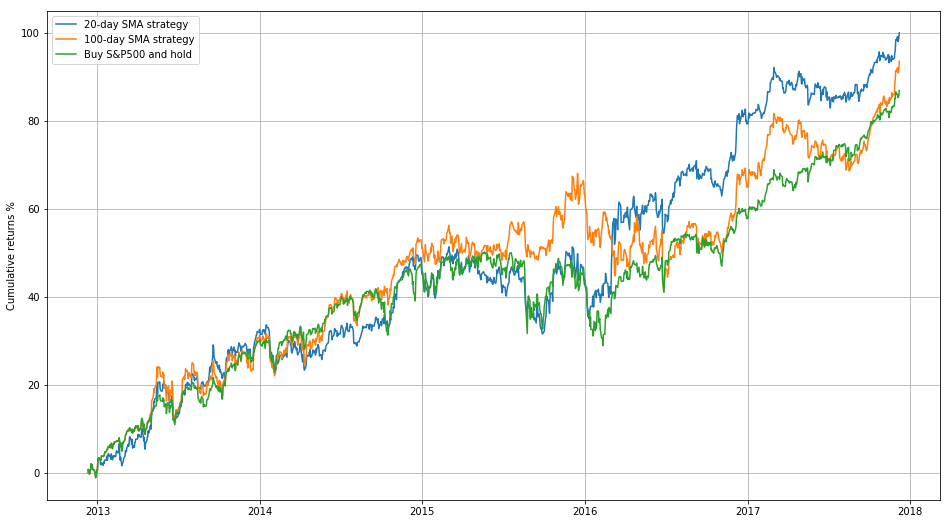

In [45]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

ax.plot(cum_strategy_returns_20sma.index, 100*cum_strategy_returns_20sma, label='20-day SMA strategy')
ax.plot(cum_strategy_returns_100sma.index, 100*cum_strategy_returns_100sma, label='100-day SMA strategy')
ax.plot(cum_sp500_returns.index, 100*cum_sp500_returns, label='Buy S&P500 and hold')

ax.set_ylabel('Cumulative returns %')
ax.legend(loc='best')
ax.grid()

plt.show()

Most investors tend to think in terms of annualized returns. In the code snippet below we convert the cumulative returns calculated above into their annual equivalents

In [62]:
def calc_annual_return(cum_return, num_days):
    return (1 + cum_return)**(250/num_days) - 1

def convert_dec_to_pct(decimal_return):
    pct_return = 100 * decimal_return
    decimal_pos = str(pct_return).index('.')
    return str(pct_return)[:(decimal_pos + 3)]

In [63]:
# Assume 250 trading days in a year
ann_return_20sma = convert_dec_to_pct(calc_annual_return(cum_strategy_returns_20sma[-1], 5*250))
ann_return_100sma = convert_dec_to_pct(calc_annual_return(cum_strategy_returns_100sma[-1], 5*250))
ann_return_sp500 = convert_dec_to_pct(calc_annual_return(cum_sp500_returns[-1], 5*250))

print('Annual returns of the following strategies are')
print('20-day SMA: {}%'.format(ann_return_20sma))
print('100-day SMA: {}%'.format(ann_return_100sma))
print('S&P 500: {}%'.format(ann_return_sp500))

Annual returns of the following strategies are
20-day SMA: 14.87%
100-day SMA: 14.13%
S&P 500: 13.32%


While at first glimpse both the 20-day and the 100-day SMA strategies seem to have outperformed the S&P 500, it's important to note that we are not factoring in transactions costs in our backtest. In the real world, that can be quite significant and can eat into trading profits.

It's also noticeable that the cumulative returns of the two active strategies roughly follow the same pattern as that for the S&P 500. One way to potentially improve the strategy and add some diversification benefit is to introduce a different asset class, such as bond.